# Interactive Performance Metrics Pipeline

This notebook demonstrates how to use the refactored performance metric extraction functions from `performance_utils.py` to calculate metrics from MATB data.

## 1. Calculate metrics for all participants
Import required libraries

In [14]:
import os
import pandas as pd
import numpy as np

from performance_utils import sysmon_measures, comms_measures, track_measures, resman_measures

Set the data directory and find all the csv files containing the eye gaze data

In [15]:
# Set the directory containing your eye tracker CSV files

# Prompt the user to input the PNAS-MATB folder path
directory = input("Enter the full path to your PNAS-MATB folder: ")
matb_directory = os.path.join(directory, "matb_outputs")

# List available CSV files
matb_files = [f for f in os.listdir(matb_directory) if f.endswith('.csv')]
print(f"Found {len(matb_files)} files. Example: {matb_files[:3]}")

Found 129 files. Example: ['3105_session01.csv', '3105_session02.csv', '3105_session03.csv']


Process all files and generate a single dataframe of metrics (accuracy and reaction times) in each window for all participants.

In [16]:
all_metrics_df = pd.DataFrame()
for file in matb_files:
    df_matb = pd.read_csv(os.path.join(matb_directory, file))
    print(f"\nProcessing file: {file}")
    partid = file.split('_')[0]
    session = file.split('_')[1].replace('session', '').replace('.csv', '')
    df_event_performace = df_matb[(df_matb['type'] == 'event') | (df_matb['type'] == 'performance')].copy()
    df_event_performace['scenario_time'] = df_event_performace['scenario_time'].astype(float)
    sysmon_failure_rate, sysmon_average_reaction_times, _,_ = sysmon_measures(df_event_performace)
    comms_failure_rate, comms_events, comms_own_events, comms_average_reaction_times = comms_measures(df_event_performace)
    track_failure_rate = track_measures(df_event_performace)
    resman_failure_rate = resman_measures(df_event_performace)
    n_windows = len(sysmon_failure_rate)
    window_starts = [w * 30 for w in range(n_windows)]
    window_ends = [start + 60 for start in window_starts]
    metrics_df = pd.DataFrame({
        'participant_id': partid,
        'session_number': session,
        'window_index': list(range(n_windows)),
        'start_time': window_starts,
        'end_time': window_ends,
        'sysmon_failure_rate': sysmon_failure_rate,
        'sysmon_average_reaction_times': sysmon_average_reaction_times,
        'comms_failure_rate': comms_failure_rate,
        'comms_events': comms_events,
        'comms_own_events': comms_own_events,
        'comms_average_reaction_times': comms_average_reaction_times,
        'track_failure_rate': track_failure_rate,
        'resman_failure_rate': resman_failure_rate
    })
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)


Processing file: 3105_session01.csv

Processing file: 3105_session02.csv

Processing file: 3105_session03.csv

Processing file: 3206_session01.csv

Processing file: 3206_session02.csv

Processing file: 3206_session03.csv

Processing file: 3207_session01.csv

Processing file: 3207_session02.csv

Processing file: 3207_session03.csv

Processing file: 3208_session01.csv

Processing file: 3208_session02.csv

Processing file: 3208_session03.csv

Processing file: 3209_session01.csv

Processing file: 3209_session02.csv

Processing file: 3209_session03.csv

Processing file: 3210_session01.csv

Processing file: 3210_session02.csv

Processing file: 3210_session03.csv

Processing file: 3214_session01.csv

Processing file: 3214_session02.csv

Processing file: 3214_session03.csv

Processing file: 3215_session01.csv

Processing file: 3215_session02.csv

Processing file: 3215_session03.csv

Processing file: 3216_session01.csv

Processing file: 3216_session02.csv

Processing file: 3216_session03.csv



Calculate average performace metrics in each window

In [17]:
all_metrics_df['average_accuracy'] = 100 - (all_metrics_df['sysmon_failure_rate'] + all_metrics_df['comms_failure_rate'] + all_metrics_df['track_failure_rate'] + all_metrics_df['resman_failure_rate']) / 4
all_metrics_df['average_reaction_time'] = all_metrics_df[['sysmon_average_reaction_times', 'comms_average_reaction_times']].mean(axis=1)/1000  # Convert to seconds

Save data for further analysis. Skip if you want to just get the stats results and plots

In [18]:
output_csv = os.path.join('..', 'rf training data', 'performance_metrics.csv')
all_metrics_df.to_csv(output_csv, index=False)
print(f"Saved all metrics to {output_csv}")

Saved all metrics to ..\rf training data\performance_metrics.csv


# 2. Run stats and plot figures using stats_figures utilities
Import relevant libraries and set the metrics for analysis (Average accuracy and Reaction time)

In [19]:
import sys
sys.path.append('..')  # Add parent directory to path
from stats_figures import run_rpy2_lmer, barplot_ax
import matplotlib.pyplot as plt
# Define metrics and labels
metrics = [
            ("average_accuracy", "Average accuracy (%)"),
            ("average_reaction_time", "Average reaction time (s)")
]

Load session info for all participants and add relevant dependent variables to all_metrics_df

In [20]:
# Load session information
Session_Info = pd.read_csv(
    os.path.join(directory,"participant_info.csv")
)
# Add session_order column to Session_Info
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

# Map 'condition' from Session_Info to all_metrics_df using participant_id and session_number
def get_condition(row):
    pid = int(row['participant_id'])
    session_col = f"session{row['session_number']}"
    if pid in Session_Info["Participant ID"].values and session_col in Session_Info.columns:
        cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
        if len(cond) > 0:
            return cond[0]
    return None
all_metrics_df["condition"] = all_metrics_df.apply(get_condition, axis=1)
# Prepare session_order and session_order_numeric maps
session_order_numeric_map = {"LMH": 1, "LHM": 2}
# Map session_order_numeric from Session_Info to all_metrics_df using participant_id
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    all_metrics_df["session_order_numeric"] = all_metrics_df["participant_id"].astype(int).map(session_info_numeric_map)

Run stats and make plots for the metrics of interest


--- Average accuracy (%) ---
Means for average_accuracy:
  H: 59.713
  L: 83.455
  M: 77.142

=== Average accuracy (%) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: average_accuracy ~ condition + session_order_numeric + window_index +  
    (1 | participant_id)
   Data: dat

REML criterion at convergence: 14190.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4691 -0.6475  0.0528  0.6793  2.7124 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 117.7    10.851  
 Residual                    82.0     9.055  
Number of obs: 1935, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             81.42144    5.50136   41.30305  14.800  < 2e-16 ***
condition.L            -16.78768    0.35655 1889.00000 -47.083  < 2e-16 ***
condition.Q             -4.53842    0.35655 1889.00000 -12.729  < 2e

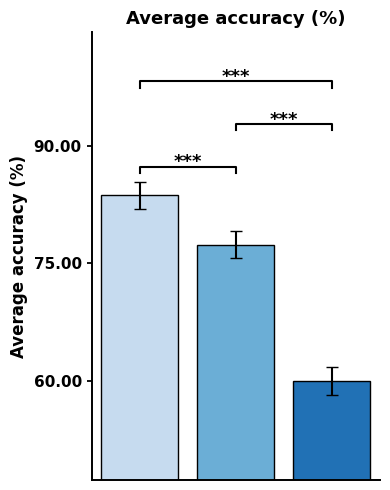


--- Average reaction time (s) ---
Means for average_reaction_time:
  H: 2.802
  L: 2.234
  M: 2.941

=== Average reaction time (s) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
average_reaction_time ~ condition + session_order_numeric + window_index +  
    (1 | participant_id)
   Data: dat

REML criterion at convergence: 8633.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4166 -0.7770 -0.3346  0.6437  4.3079 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 0.1162   0.3408  
 Residual                   4.9572   2.2265  
Number of obs: 1935, groups:  participant_id, 43

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.056e+00  2.526e-01  5.122e+01  12.101  < 2e-16 ***
condition.L            4.018e-01  8.767e-02  1.889e+03   4.583 4.89e-06 ***
condition.Q           -3.456e-01  8.767e-02  1.889e

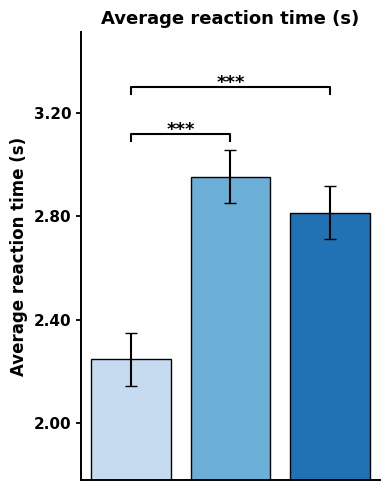

In [21]:
# Use the all_metrics_df from previous cell
if 'all_metrics_df' in locals():
    for metric, label in metrics:
        print(f"\n--- {label} ---")
        # Run mixed effects model and get stats
        pairwise_p, means, cis = run_rpy2_lmer(
            all_metrics_df, metric, label
        )
        # Prepare data for plotting
        conds = ["L", "M", "H"]
        mean_vals = [means.get(c, float('nan')) for c in conds]
        sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
        pvals = [pairwise_p.get(("L", "M"), 1.0), pairwise_p.get(("L", "H"), 1.0), pairwise_p.get(("M", "H"), 1.0)]
        # Plot
        fig, ax = plt.subplots(figsize=(4, 5))
        barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
        ax.set_title(label, fontsize=13, weight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("all_metrics_df not found. Please run the previous cell to generate metrics.")